# DCGAN with MNIST

* MNIST data를 가지고 **Deep Convolution GAN**를 `tf.contrib.slim`을 이용하여 만들어보자.
  * [참고: TensorFlow slim](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)

In [1]:
#Connected google drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

In [0]:
#make data directory
!mkdir -p drive
!google-drive-ocamlfuse drive

## Import modules

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline


import tensorflow as tf

slim = tf.contrib.slim
tf.logging.set_verbosity(tf.logging.INFO)

#tf.set_random_seed(219)
#np.random.seed(219)

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
!cd ./drive/gan/BEGAN-tensorflow-master/data/sample/

/bin/sh: 1: cd: can't cd to ./drive/gan/BEGAN-tensorflow-master/data/sample/


In [0]:
# Training Flags (hyperparameter configuration)
train_dir = './drive/gan/BEGAN-tensorflow-master/data/'
max_epochs = 30
save_epochs = 10
summary_steps = 2500
print_steps = 1000
batch_size = 64
learning_rate_D = 0.0002
learning_rate_G = 0.001
k = 1 # the number of step of learning D before learning G
num_samples = 16

## Import MNIST

In [0]:
import os
import cv2

In [0]:
#path_dir = '/Users/home/Downloads/agar_plate_ey/'
file_list = os.listdir(train_dir)

print(file_list)

['img_611.jpg', 'img_608.jpg', 'img_612.jpg', 'img_606.jpg', 'img_613.jpg', 'img_615.jpg', 'img_620.jpg', 'img_618.jpg', 'img_621.jpg', 'img_624.jpg', 'img_617.jpg', 'img_623.jpg', 'img_616.jpg', 'img_622.jpg', 'img_619.jpg', 'img_625.jpg', 'img_629.jpg', 'img_633.jpg', 'img_626.jpg', 'img_632.jpg', 'img_627.jpg', 'img_634.jpg', 'img_628.jpg', 'img_631.jpg', 'img_630.jpg', 'img_635.jpg', 'img_639.jpg', 'img_640.jpg', 'img_636.jpg', 'img_641.jpg', 'img_643.jpg', 'img_644.jpg', 'img_642.jpg', 'img_637.jpg', 'img_638.jpg', 'img_645.jpg', 'img_646.jpg', 'img_650.jpg', 'img_649.jpg', 'img_652.jpg', 'img_654.jpg', 'img_653.jpg', 'img_647.jpg', 'img_651.jpg', 'img_648.jpg', 'img_655.jpg', 'img_661.jpg', 'img_663.jpg', 'img_657.jpg', 'img_658.jpg', 'img_656.jpg', 'img_660.jpg', 'img_662.jpg', 'img_664.jpg', 'img_659.jpg', 'img_665.jpg', 'img_674.jpg', 'img_670.jpg', 'img_671.jpg', 'img_667.jpg', 'img_669.jpg', 'img_666.jpg', 'img_673.jpg', 'img_672.jpg', 'img_668.jpg', 'img_675.jpg', 'img_679.

In [0]:
train_data = []
for i in enumerate(file_list):
    img = cv2.imread(train_dir + i[1], 0)
    #img = np.array(img)
    #print(img.shape)
    img = img / 255
    train_data.append(img)
    
train_data = np.asanyarray(train_data)

KeyboardInterrupt: ignored

In [0]:
train_data = np.load('./drive/my_database.npy')

In [0]:
train_data.shape

(70400, 28, 28)

## Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [0]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count=max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

<BatchDataset shapes: (?, 28, 28), types: tf.float64>


## Create the model

In [0]:
class DCGAN(object):
  """Deep Convolutional Generative Adversarial Networks
  implementation based on http://arxiv.org/abs/1511.06434
  
  "Unsupervised Representation Learning with
  Deep Convolutional Generative Adversarial Networks"
  Alec Radford, Luke Metz and Soumith Chintala
  """
  
  def __init__(self, mode, train_dataset, test_dataset=None):
    """Basic setup.
    
    Args:
      mode (`string`): "train" or "generate".
      train_dataset (`tf.data.Dataset`): train_dataset.
      test_dataset (`tf.data.Dataset`): test_dataset.
    """
    assert mode in ["train", "generate"]
    self.mode = mode
    
    # hyper-parameters for model
    self.x_dim = 28
    self.z_dim = 100
    self.batch_size = batch_size
    self.num_samples = num_samples
    self.train_dataset = train_dataset
    self.test_dataset = test_dataset
    
    # Global step Tensor.
    self.global_step = None
    
    print('The mode is %s.' % self.mode)
    print('complete initializing model.')
    
    
  def build_random_z_inputs(self):
    """Build a vector random_z in latent space.
    
    Returns:
      self.random_z (`4-rank Tensor` with [batch_size, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
      self.sample_random_z (`4-rank Tensor` with [num_samples, 1, 1, z_dim]):
          latent vector which size is generally 100 dim.
    """
    # 여기를 채워 넣으세요
    # Setup variable of random vector z
    with tf.variable_scope('random_z'):
      self.random_z = tf.random_uniform(shape=[self.batch_size, 1, 1, self.z_dim],
                                        minval=-1.0, maxval=1.0)
      self.sample_random_z = tf.random_uniform(shape=[self.num_samples, 1, 1, self.z_dim],
                                               minval=-1.0, maxval=1.0)

    return self.random_z, self.sample_random_z
  
  
  def read_MNIST(self, dataset):
    """Read MNIST dataset
    
    Args:
      dataset (`tf.data.Dataset` format): MNIST dataset.
      
    Returns:
      self.mnist (`4-rank Tensor` with [batch, x_dim, x_dim, 1]): MNIST dataset with batch size.
    """
    with tf.variable_scope('mnist'):
      iterator = dataset.make_one_shot_iterator()

      self.mnist = iterator.get_next()
      self.mnist = tf.cast(self.mnist, dtype = tf.float32)
      self.mnist = tf.expand_dims(self.mnist, axis=3)
      
    return self.mnist


  def Generator(self, random_z, is_training=True, reuse=False):
    """Generator setup.
    
    Args:
      random_z (`2-rank Tensor` with [batch_size, z_dim]):
          latent vector which size is generally 100 dim.
      is_training (`bool`): whether training mode or test mode.
      reuse (`bool`): whether variable reuse or not.
      
    Returns:
      generated_data (`4-rank Tensor` with [batch_size, h, w, c])
          generated images from random vector z.
    """
    with tf.variable_scope('Generator', reuse=reuse) as scope:
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'is_training': is_training,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d_transpose],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        # 여기를 채워 넣으세요
        # Use full conv2d_transpose instead of projection and reshape
        # random_z: 1 x 1 x 100 dim
        self.inputs = random_z
        # inputs = random_z: 1 x 1 x 100 dim
        # outputs: 3 x 3 x 256 dim
        self.layer1 = slim.conv2d_transpose(inputs=self.inputs,
                                            num_outputs=256,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer1')
        # inputs: 3 x 3 x 256 dim
        # outputs: 7 x 7 x 128 dim
        self.layer2 = slim.conv2d_transpose(inputs=self.layer1,
                                            num_outputs=128,
                                            kernel_size=[3, 3],
                                            padding='VALID',
                                            scope='layer2')
        # inputs: 7 x 7 x 128 dim
        # outputs: 14 x 14 x 64 dim
        self.layer3 = slim.conv2d_transpose(inputs=self.layer2,
                                            num_outputs=64,
                                            scope='layer3')
        # inputs: 14 x 14 x 64 dim
        # outputs: 28 x 28 x 1 dim
        self.layer4 = slim.conv2d_transpose(inputs=self.layer3,
                                            num_outputs=1,
                                            normalizer_fn=None,
                                            activation_fn=tf.sigmoid,
                                            scope='layer4')
        # generated_data = outputs: 28 x 28 x 1 dim
        generated_data = self.layer4

        return generated_data
    
    
  def Discriminator(self, data, reuse=False):
    """Discriminator setup.
    
    Args:
      data (`2-rank Tensor` with [batch_size, x_dim]): MNIST real data.
      reuse (`bool`): whether variable reuse or not.
      
    Returns:
      logits (`1-rank Tensor` with [batch_size]): logits of data.
    """
    with tf.variable_scope('Discriminator', reuse=reuse) as scope:
      batch_norm_params = {'decay': 0.9,
                           'epsilon': 0.001,
                           'scope': 'batch_norm'}
      with slim.arg_scope([slim.conv2d],
                          kernel_size=[4, 4],
                          stride=[2, 2],
                          activation_fn=tf.nn.leaky_relu,
                          normalizer_fn=slim.batch_norm,
                          normalizer_params=batch_norm_params):
        # 여기를 채워 넣으세요
        # inputs = data: 28 x 28 x 1 dim
        # outputs: 14 x 14 x 64 dim
        self.layer1 = slim.conv2d(inputs=data,
                                  num_outputs=64,
                                  normalizer_fn=None,
                                  scope='layer1')
        # inputs: 14 x 14 x 64 dim
        # outputs: 7 x 7 x 128 dim
        self.layer2 = slim.conv2d(inputs=self.layer1,
                                  num_outputs=128,
                                  scope='layer2')
        # inputs: 7 x 7 x 128 dim
        # outputs: 3 x 3 x 256 dim
        self.layer3 = slim.conv2d(inputs=self.layer2,
                                  num_outputs=256,
                                  kernel_size=[3, 3],
                                  padding='VALID',
                                  scope='layer3')
        # inputs: 3 x 3 x 256 dim
        # outputs: 1 x 1 x 1 dim
        self.layer4 = slim.conv2d(inputs=self.layer3,
                                  num_outputs=1,
                                  kernel_size=[3, 3],
                                  stride=[1, 1],
                                  padding='VALID',
                                  normalizer_fn=None,
                                  activation_fn=None,
                                  scope='layer4')
        # logits = layer4: 1 x 1 x 1 dim -> 1 dim
        discriminator_logits = tf.squeeze(self.layer4, axis=[1, 2])

        return discriminator_logits
    
    
  def setup_global_step(self):
    """Sets up the global step Tensor."""
    if self.mode == "train":
      self.global_step = tf.train.get_or_create_global_step()
      
      print('complete setup global_step.')
      
      
  def GANLoss(self, logits, is_real=True, scope=None):
    """Computes standard GAN loss between `logits` and `labels`.
    
    Args:
      logits (`1-rank Tensor`): logits.
      is_real (`bool`): True means `1` labeling, False means `0` labeling.
      
    Returns:
      loss (`0-randk Tensor): the standard GAN loss value. (binary_cross_entropy)
    """
    if is_real:
      labels = tf.ones_like(logits)
    else:
      labels = tf.zeros_like(logits)

    # 여기를 채워 넣으세요
    loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=labels,
                                           logits=logits,
                                           scope=scope)

    return loss

      
  def build(self):
    """Creates all ops for training or generate."""
    self.setup_global_step()
    
    if self.mode == "generate":
      pass
    
    else:
      # generating random vector
      self.random_z, self.sample_random_z = self.build_random_z_inputs()
      # read dataset
      self.real_data = self.read_MNIST(self.train_dataset)
      
      # 여기를 채워 넣으세요
      # generating images from Generator() via random vector z
      self.generated_data = self.Generator(self.random_z)
      
      # 여기를 채워 넣으세요
      # discriminating real data by Discriminator()
      self.real_logits = self.Discriminator(self.real_data)
      # discriminating fake data (generated)_images) by Discriminator()
      self.fake_logits = self.Discriminator(self.generated_data, reuse=True)
      
      # 여기를 채워 넣으세요
      # losses of real with label "1"
      self.loss_real = self.GANLoss(self.real_logits, is_real=True, scope='loss_D_real')
      # losses of fake with label "0"
      self.loss_fake = self.GANLoss(self.fake_logits, is_real=False, scope='loss_D_fake')
      
      # losses of Discriminator
      with tf.variable_scope('loss_D'):
        self.loss_Discriminator = self.loss_real + self.loss_fake
        
      # 여기를 채워 넣으세요
      # losses of Generator with label "1" that used to fool the Discriminator
      self.loss_Generator = self.GANLoss(self.fake_logits, is_real=True, scope='loss_G')
      
      # 여기를 채워 넣으세요
      # Separate variables for each function
      self.D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')
      self.G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
      
      
      # generating images for sample
      self.sample_data = self.Generator(self.sample_random_z, is_training=False, reuse=True)
      
      # write summaries
      # Add loss summaries
      tf.summary.scalar('losses/loss_Discriminator', self.loss_Discriminator)
      tf.summary.scalar('losses/loss_Generator', self.loss_Generator)
      
      # Add histogram summaries
      for var in self.D_vars:
        tf.summary.histogram(var.op.name, var)
      for var in self.G_vars:
        tf.summary.histogram(var.op.name, var)
      
      # Add image summaries
      tf.summary.image('random_images', self.generated_data, max_outputs=4)
      tf.summary.image('real_images', self.real_data)
      
    print('complete model build.\n')

## Define plot function

In [0]:
def print_sample_data(sample_data, max_print=num_samples):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  
  plt.figure(figsize=(max_print, 1))
  plt.axis('off')
  plt.imshow(print_images, cmap='gray')
  plt.show()

In [0]:
def save_sample_data(sample_data, global_step_, epochs, max_print=num_samples):
  print_images = sample_data[:max_print,:]
  print_images = print_images.reshape([max_print, 28, 28])
  print_images = print_images.swapaxes(0, 1)
  print_images = print_images.reshape([28, max_print * 28])
  str = './drive/gan/BEGAN-tensorflow-master/data/sample/img(' + np.str(global_step_) + 'epochs : ' + np.str(epochs) + ').jpg'
  cv2.imwrite(str, sample_data)

## Build a model

In [0]:
tf.reset_default_graph()

In [0]:
model = DCGAN(mode="train", train_dataset=train_dataset)
model.build()

# show info for trainable variables
t_vars = tf.trainable_variables()
slim.model_analyzer.analyze_vars(t_vars, print_info=True)

The mode is train.
complete initializing model.
complete setup global_step.
complete model build.

---------
Variables: name (type shape) [size]
---------
Generator/layer1/weights:0 (float32_ref 3x3x256x100) [230400, bytes: 921600]
Generator/layer1/batch_norm/beta:0 (float32_ref 256) [256, bytes: 1024]
Generator/layer2/weights:0 (float32_ref 3x3x128x256) [294912, bytes: 1179648]
Generator/layer2/batch_norm/beta:0 (float32_ref 128) [128, bytes: 512]
Generator/layer3/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Generator/layer3/batch_norm/beta:0 (float32_ref 64) [64, bytes: 256]
Generator/layer4/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Generator/layer4/biases:0 (float32_ref 1) [1, bytes: 4]
Discriminator/layer1/weights:0 (float32_ref 4x4x1x64) [1024, bytes: 4096]
Discriminator/layer1/biases:0 (float32_ref 64) [64, bytes: 256]
Discriminator/layer2/weights:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
Discriminator/layer2/batch_norm/beta:0 (float32_ref 128) [

(1087618, 4350472)

In [0]:
opt_D = tf.train.AdamOptimizer(learning_rate=learning_rate_D, beta1=0.5)
opt_G = tf.train.AdamOptimizer(learning_rate=learning_rate_G, beta1=0.5)

In [0]:
# 여기를 채워 넣으세요
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')):
  opt_D_op = opt_D.minimize(model.loss_Discriminator, var_list=model.D_vars)
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')):
  opt_G_op = opt_G.minimize(model.loss_Generator, global_step=model.global_step,
                            var_list=model.G_vars)

### Assign `tf.summary.FileWriter`

In [0]:
graph_location = train_dir
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: ./drive/gan/BEGAN-tensorflow-master/data/sample/


### `tf.summary`

In [0]:
summary_op = tf.summary.merge_all()

### `tf.train.Saver`

In [0]:
saver = tf.train.Saver(tf.global_variables(), max_to_keep=1000)

### `tf.Session` and train

In [0]:
704 / 64

11.0

INFO:tensorflow:Start Session.
Epochs: 0.00 global_step: 0 loss_D: 1.187 loss_G: 1.845 (15.78 examples/sec; 4.055 sec/batch)


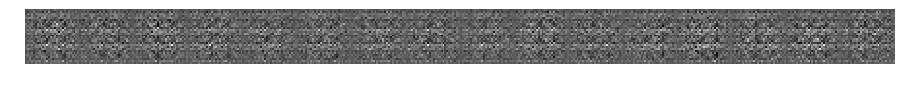

generated_data


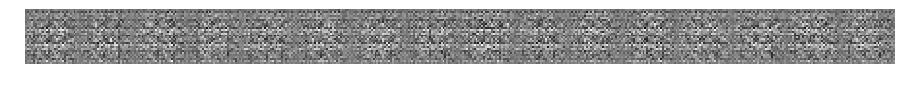

Epochs: 0.91 global_step: 1000 loss_D: 0.841 loss_G: 0.831 (1832.09 examples/sec; 0.035 sec/batch)


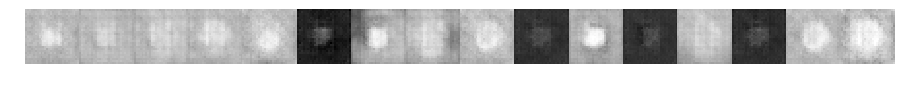

generated_data


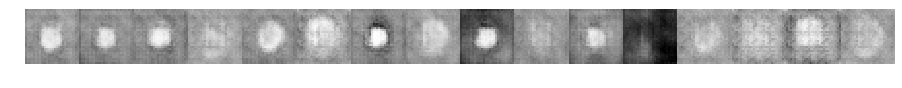

Epochs: 1.82 global_step: 2000 loss_D: 0.984 loss_G: 1.725 (1864.64 examples/sec; 0.034 sec/batch)


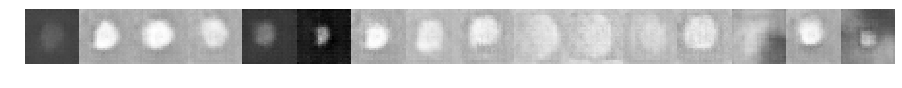

generated_data


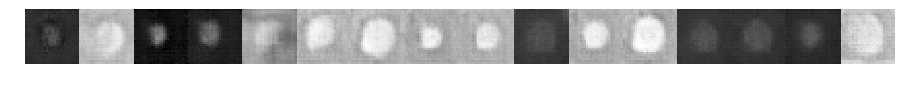

Epochs: 2.73 global_step: 3000 loss_D: 0.342 loss_G: 0.945 (1863.22 examples/sec; 0.034 sec/batch)


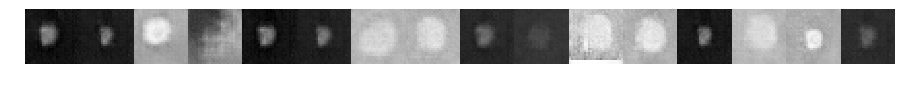

generated_data


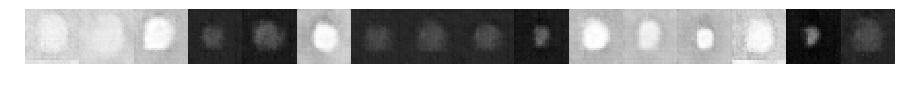

Epochs: 3.64 global_step: 4000 loss_D: 0.844 loss_G: 1.557 (1859.76 examples/sec; 0.034 sec/batch)


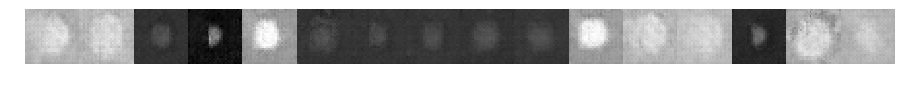

generated_data


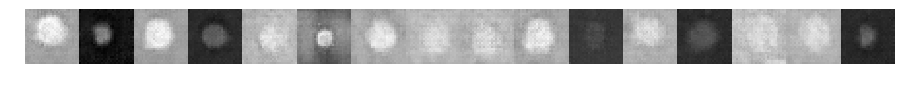

Epochs: 4.55 global_step: 5000 loss_D: 0.142 loss_G: 1.262 (1877.72 examples/sec; 0.034 sec/batch)


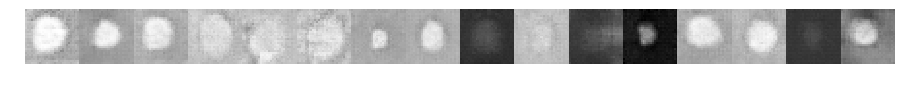

generated_data


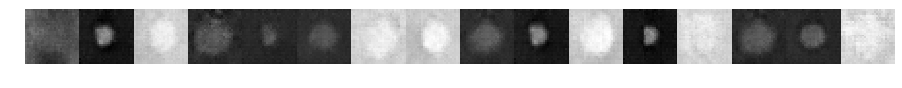

Epochs: 5.45 global_step: 6000 loss_D: 0.439 loss_G: 1.007 (1851.87 examples/sec; 0.035 sec/batch)


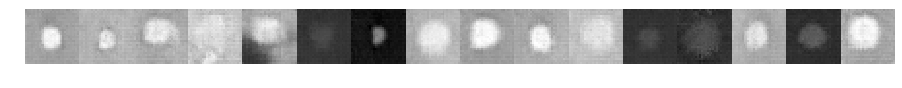

generated_data


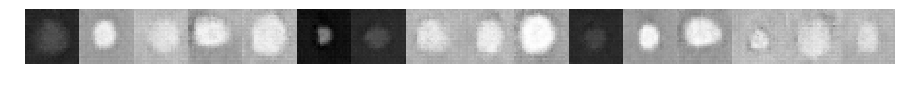

Epochs: 6.36 global_step: 7000 loss_D: 0.477 loss_G: 2.233 (1898.69 examples/sec; 0.034 sec/batch)


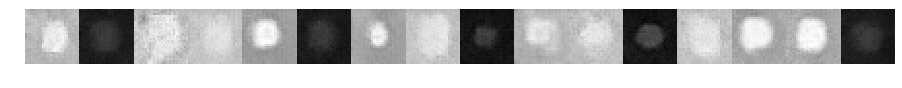

generated_data


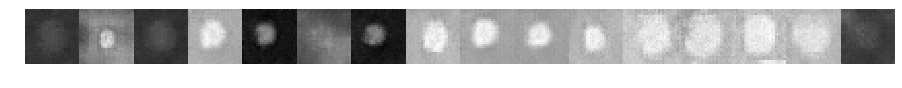

Epochs: 7.27 global_step: 8000 loss_D: 0.245 loss_G: 2.015 (1871.30 examples/sec; 0.034 sec/batch)


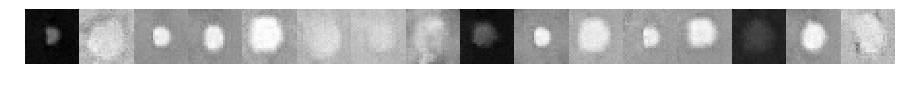

generated_data


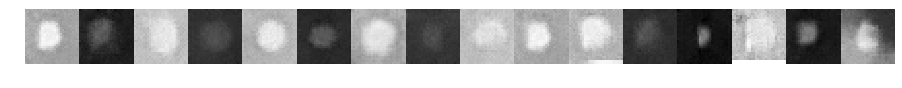

Epochs: 8.18 global_step: 9000 loss_D: 0.577 loss_G: 2.760 (1894.13 examples/sec; 0.034 sec/batch)


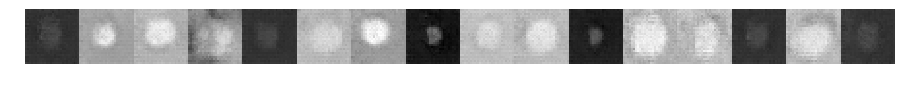

generated_data


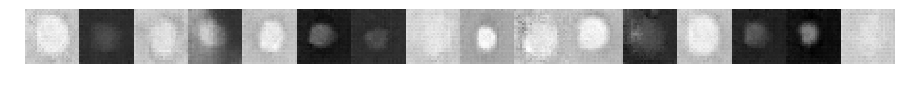

Epochs: 9.09 global_step: 10000 loss_D: 0.234 loss_G: 1.948 (1863.57 examples/sec; 0.034 sec/batch)


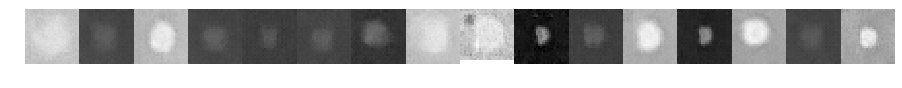

generated_data


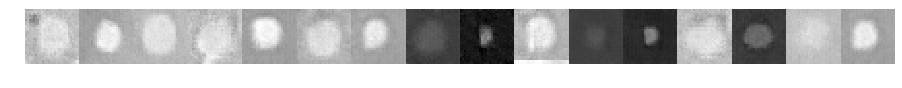

Epochs: 10.00 global_step: 11000 loss_D: 0.497 loss_G: 4.928 (1842.26 examples/sec; 0.035 sec/batch)


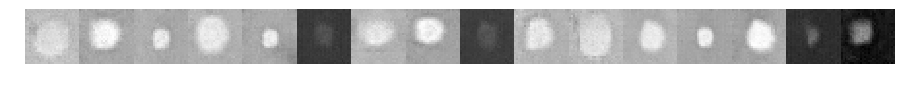

generated_data


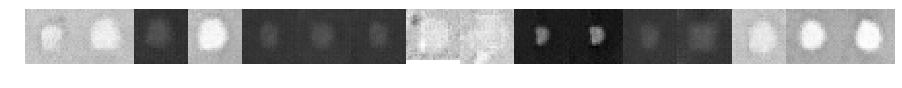

INFO:tensorflow:Saving model with global step 11000 (= 10 epochs) to disk.
Epochs: 10.91 global_step: 12000 loss_D: 0.328 loss_G: 4.902 (1848.28 examples/sec; 0.035 sec/batch)


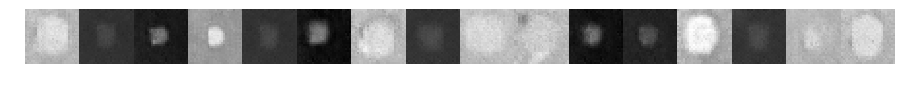

generated_data


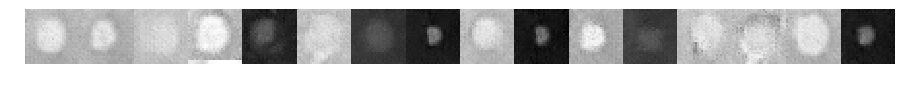

Epochs: 11.82 global_step: 13000 loss_D: 0.414 loss_G: 4.230 (1893.72 examples/sec; 0.034 sec/batch)


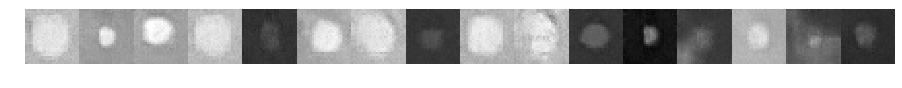

generated_data


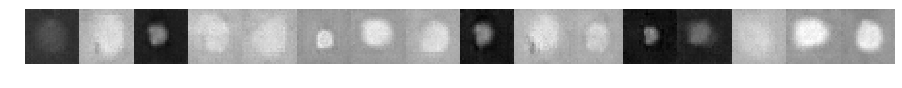

Epochs: 12.73 global_step: 14000 loss_D: 0.071 loss_G: 5.232 (1868.03 examples/sec; 0.034 sec/batch)


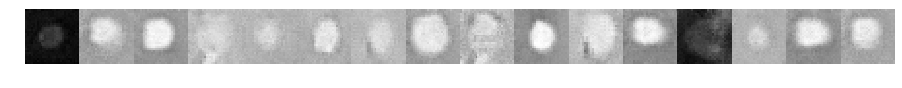

generated_data


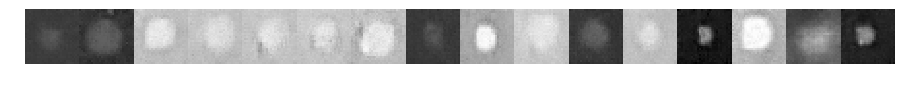

Epochs: 13.64 global_step: 15000 loss_D: 0.370 loss_G: 1.442 (1840.54 examples/sec; 0.035 sec/batch)


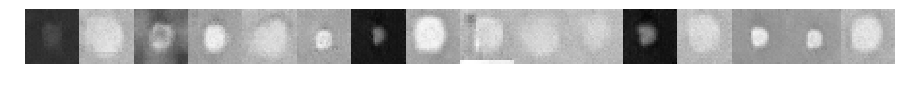

generated_data


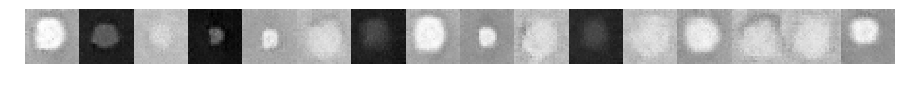

Epochs: 14.55 global_step: 16000 loss_D: 0.045 loss_G: 7.504 (1872.18 examples/sec; 0.034 sec/batch)


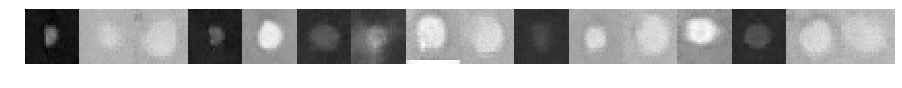

generated_data


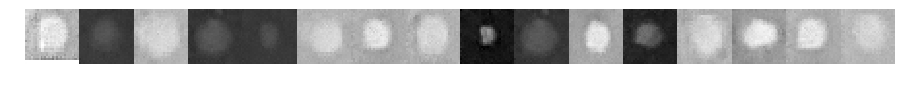

Epochs: 15.45 global_step: 17000 loss_D: 0.284 loss_G: 5.291 (1854.76 examples/sec; 0.035 sec/batch)


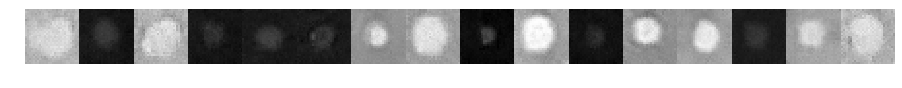

generated_data


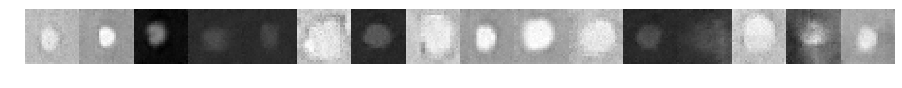

Epochs: 16.36 global_step: 18000 loss_D: 0.062 loss_G: 4.037 (1886.94 examples/sec; 0.034 sec/batch)


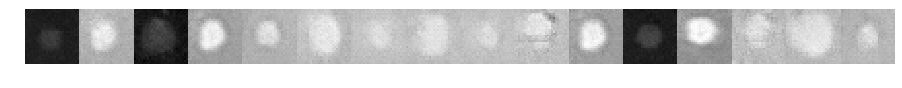

generated_data


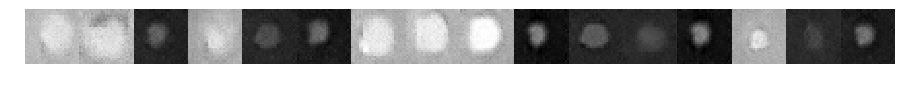

Epochs: 17.27 global_step: 19000 loss_D: 0.077 loss_G: 3.721 (1755.88 examples/sec; 0.036 sec/batch)


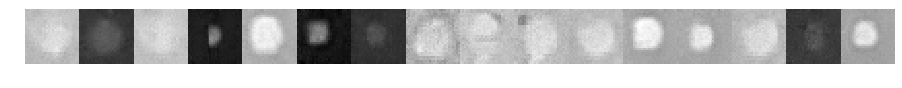

generated_data


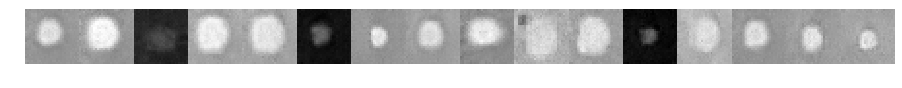

Epochs: 18.18 global_step: 20000 loss_D: 0.966 loss_G: 5.174 (1854.66 examples/sec; 0.035 sec/batch)


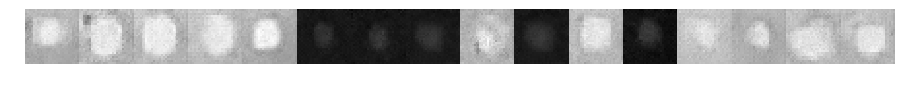

generated_data


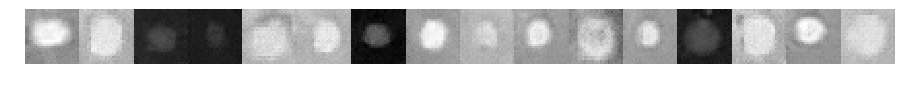

Epochs: 19.09 global_step: 21000 loss_D: 0.021 loss_G: 2.319 (1892.56 examples/sec; 0.034 sec/batch)


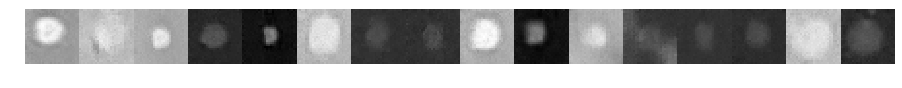

generated_data


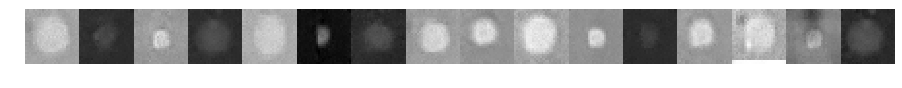

Epochs: 20.00 global_step: 22000 loss_D: 0.084 loss_G: 2.539 (1830.86 examples/sec; 0.035 sec/batch)


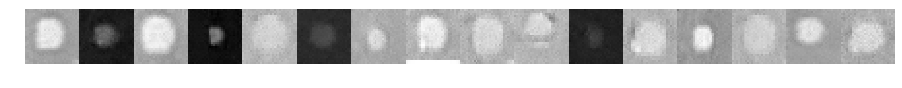

generated_data


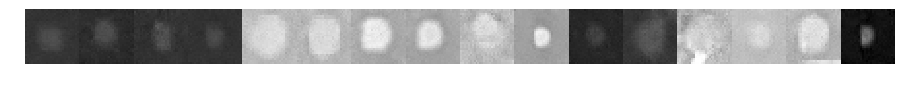

INFO:tensorflow:Saving model with global step 22000 (= 20 epochs) to disk.
Epochs: 20.91 global_step: 23000 loss_D: 0.058 loss_G: 5.900 (1867.60 examples/sec; 0.034 sec/batch)


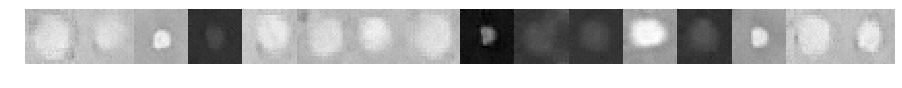

generated_data


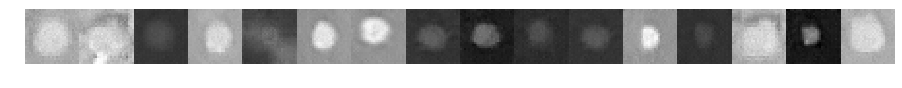

Epochs: 21.82 global_step: 24000 loss_D: 0.096 loss_G: 4.583 (1861.76 examples/sec; 0.034 sec/batch)


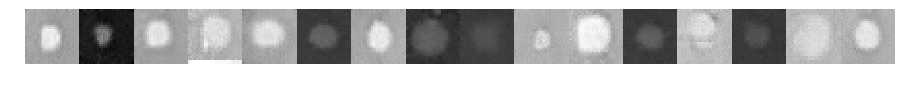

generated_data


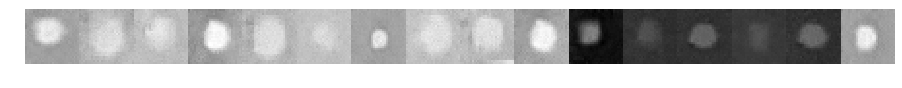

Epochs: 22.73 global_step: 25000 loss_D: 1.860 loss_G: 4.243 (1856.68 examples/sec; 0.034 sec/batch)


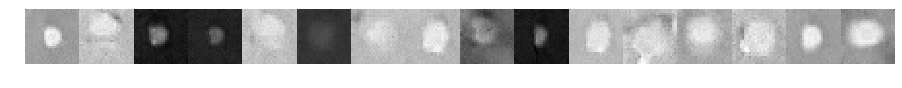

generated_data


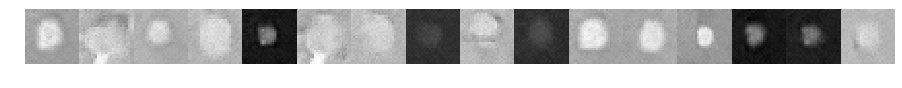

Epochs: 23.64 global_step: 26000 loss_D: 0.203 loss_G: 3.998 (1815.09 examples/sec; 0.035 sec/batch)


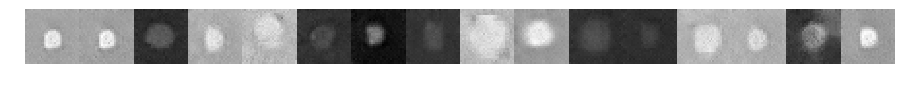

generated_data


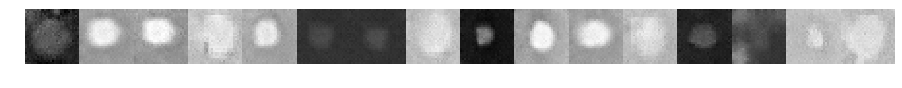

Epochs: 24.55 global_step: 27000 loss_D: 0.814 loss_G: 3.218 (1799.30 examples/sec; 0.036 sec/batch)


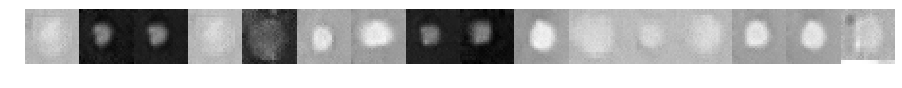

generated_data


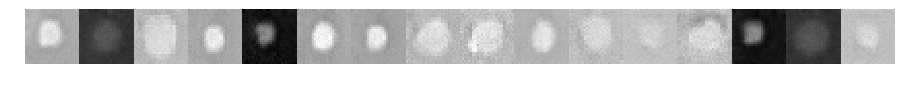

Epochs: 25.45 global_step: 28000 loss_D: 0.137 loss_G: 3.049 (1850.05 examples/sec; 0.035 sec/batch)


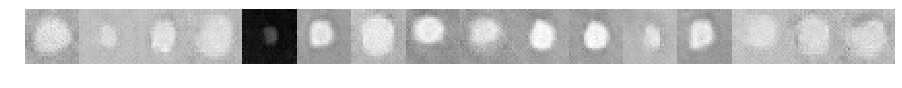

generated_data


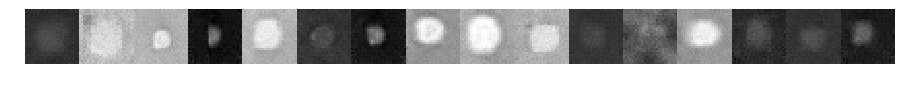

Epochs: 26.36 global_step: 29000 loss_D: 0.301 loss_G: 5.839 (1839.33 examples/sec; 0.035 sec/batch)


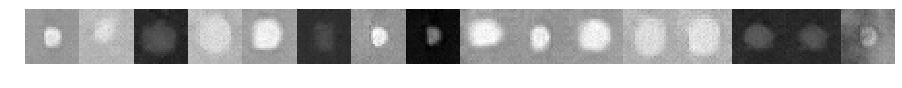

generated_data


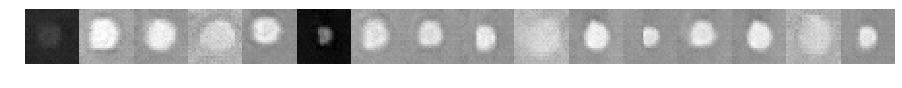

Epochs: 27.27 global_step: 30000 loss_D: 0.142 loss_G: 6.568 (1866.21 examples/sec; 0.034 sec/batch)


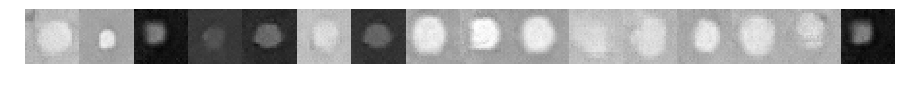

generated_data


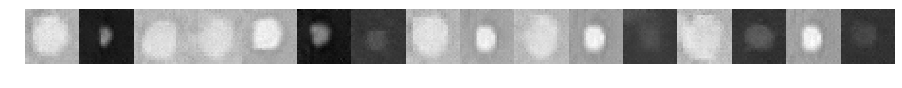

Epochs: 28.18 global_step: 31000 loss_D: 0.088 loss_G: 5.418 (1857.66 examples/sec; 0.034 sec/batch)


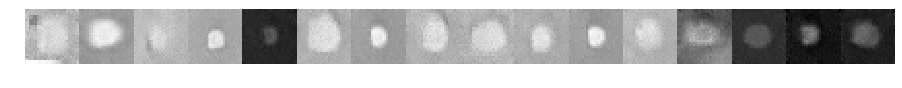

generated_data


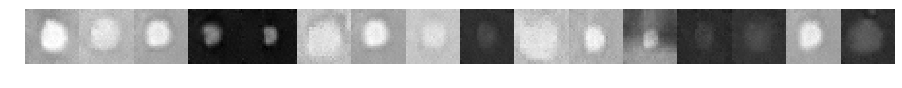

Epochs: 29.09 global_step: 32000 loss_D: 0.028 loss_G: 9.011 (1870.34 examples/sec; 0.034 sec/batch)


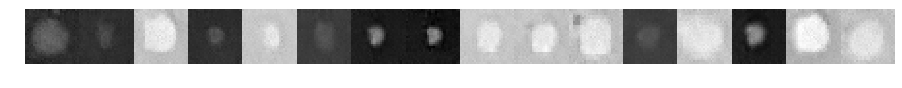

generated_data


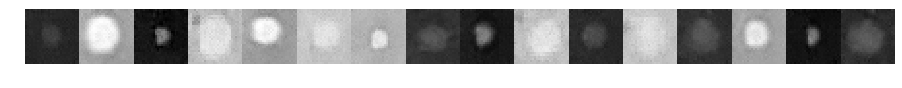

End of dataset
INFO:tensorflow:Saving model with global step 32985 (= 29 epochs) to disk.
INFO:tensorflow:complete training...


In [0]:
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
with tf.Session(config=sess_config) as sess:
  sess.run(tf.global_variables_initializer())
  tf.logging.info('Start Session.')
  
  num_examples = len(train_data)
  num_batches_per_epoch = int(num_examples / batch_size) # 704 / 64
  
  # save loss values for plot
  loss_history = []
  pre_epochs = 0
  while True:
    try:
      start_time = time.time()
      
      for _ in range(k):
        _, loss_D = sess.run([opt_D_op, model.loss_Discriminator])
      _, global_step_, loss_G = sess.run([opt_G_op,
                                          model.global_step,
                                          model.loss_Generator])
      #print('global_step_ :', global_step_)
      epochs = global_step_ * batch_size / float(num_examples)
      duration = time.time() - start_time

      if global_step_ % print_steps == 0:
        examples_per_sec = batch_size / float(duration)
        print("Epochs: {:.2f} global_step: {} loss_D: {:.3f} loss_G: {:.3f} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                  epochs, global_step_, loss_D, loss_G, examples_per_sec, duration))

        loss_history.append([epochs, loss_D, loss_G])

        # print sample data
        sample_data = sess.run(model.sample_data)
        generated_data = sess.run(model.generated_data)
        print_sample_data(sample_data)
        print('generated_data')
        print_sample_data(generated_data)
        save_sample_data(generated_data, global_step_, epochs)

      # write summaries periodically
      if global_step_ % summary_steps == 0:
        summary_str = sess.run(summary_op)
        train_writer.add_summary(summary_str, global_step=global_step_)

      # save model checkpoint periodically
      if int(epochs) % save_epochs == 0  and  pre_epochs != int(epochs):
        tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
        saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
        pre_epochs = int(epochs)
        
    except tf.errors.OutOfRangeError:
      print("End of dataset")  # ==> "End of dataset"
      tf.logging.info('Saving model with global step {} (= {} epochs) to disk.'.format(global_step_, int(epochs)))
      saver.save(sess, train_dir + 'model.ckpt', global_step=global_step_)
      break
      
  tf.logging.info('complete training...')

## Plot loss functions

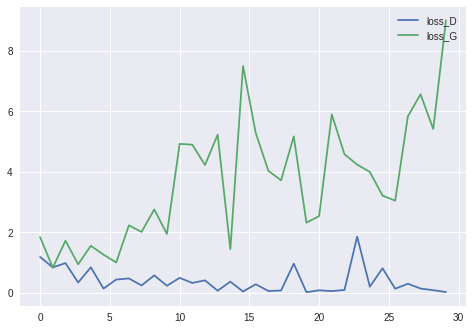

In [0]:
loss_history = np.asarray(loss_history)

plt.plot(loss_history[:,0], loss_history[:,1], label='loss_D')
plt.plot(loss_history[:,0], loss_history[:,2], label='loss_G')
plt.legend(loc='upper right')
plt.show()

In [0]:
print(loss_history[:,2])

[0.31513244 0.76218325 2.0114882  1.56777167 1.30433202 1.16862428
 2.63312364 0.69718122 1.93133283 1.64700127 1.23563254 3.07203436
 5.07556534 3.76403713 4.98675156 4.36039257 4.3579483  6.906497
 5.98270512 5.82541275 2.64441013 2.59654236 6.03004026 3.72382736
 2.33832216 2.19100952 0.82823586 6.03913641 5.10653639 2.13060451
 2.93118119 3.76853156 4.55481148]


In [0]:
print(loss_history[:,0])

[ 0.          0.90909091  1.81818182  2.72727273  3.63636364  4.54545455
  5.45454545  6.36363636  7.27272727  8.18181818  9.09090909 10.
 10.90909091 11.81818182 12.72727273 13.63636364 14.54545455 15.45454545
 16.36363636 17.27272727 18.18181818 19.09090909 20.         20.90909091
 21.81818182 22.72727273 23.63636364 24.54545455 25.45454545 26.36363636
 27.27272727 28.18181818 29.09090909]


In [0]:
  str = './drive/gan/BEGAN-tensorflow-master/data/sample/a.jpg'
  cc = cv2.imread(str)
  cc = np.asarray(cc)

In [0]:
cc = np.asarray(cc)

In [0]:
 str = './drive/gan/BEGAN-tensorflow-master/data/sample/a.jpg'
cv2.imwrite(str,cc)

True